In [1]:
import igraph as ig
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_mutual_info_score as AMI
import partition_igraph
from matplotlib import pyplot as plt
from collections import Counter
import random
import pickle
import os
import seaborn as sns
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from scipy.sparse import csr_matrix
import scipy.sparse as sparse 
import time
from statistics import mode
from abcd_graph import ABCDGraph, ABCDParams
## pip install git+https://github.com/isaranto/omega_index.git
import omega_index

import sys
sys.path.append('../')
from CAS import *


## ABCD-o graphs

* ground-truth saved in 'gt' vertex attribute


In [4]:
## this assumes community 0 are outliers and 'gt' exists in graph G
## M: membership matrix
## S: score matrix (C or Beta)
def outliers_AUC(G, M, S):
    y = [int(x>0) for x in G.vs['gt']]
    x = np.array(S.max(axis=1).todense()).flatten()
    ctr = Counter(np.array(M.sum(axis=1)).flatten())
    print('With matrix M:\noutliers:',ctr[0])
    print('correct outliers:',sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(G.vs['gt']) == 0)))
    print('\nWith scores:\noutlier AUC:',AUC(y,x)) 
        

## Investigating the bend with IEF


In [16]:
xi = 0.6
g = build_ABCDo(xi)
num_nodes = g.vcount()
A = g.get_adjacency_sparse()
g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
L = []

## Compute Beta, C; M is the community membership matrix w.r.t. C and c_star 
IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
g.vs['IEF'] = IEF.max(axis=1).toarray().flatten()
g.vs['beta'] = Beta.max(axis=1).toarray().flatten()
g.vs['C'] = C.max(axis=1).toarray().flatten()
g.vs['P'] = P.max(axis=1).toarray().flatten()

## rank w.r.t. top score, AMI w.r.t. original partition
r_ief = np.argsort(g.vs['IEF'])
for k in range(num_nodes//10):
    L.append([xi, 'IEF', k, AMI( np.array(g.vs['leiden'])[r_ief[k:]] , np.array(g.vs['gt'])[r_ief[k:]] )])        
r_beta = np.argsort(g.vs['beta'])
for k in range(num_nodes//10):
    L.append([xi, 'beta', k, AMI( np.array(g.vs['leiden'])[r_beta[k:]] , np.array(g.vs['gt'])[r_beta[k:]] )])        



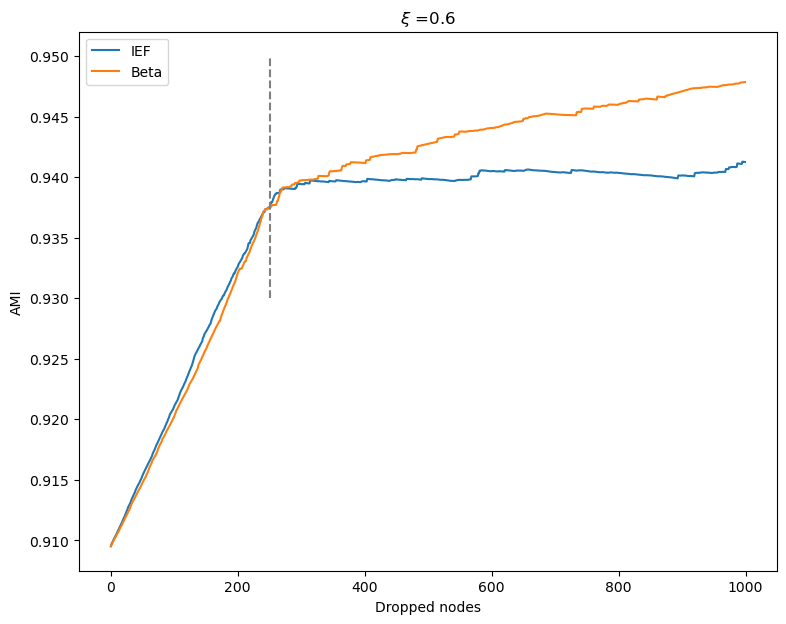

In [18]:
plt.figure(figsize=(9,7))
df = pd.DataFrame(L, columns=['xi','algo','dropped','ami']) 

D = df
D = D.groupby(by=['dropped','algo'])['ami'].mean()
plt.plot(D.loc[:,'IEF'].index, D.loc[:,'IEF'], label='IEF')
plt.plot(D.loc[:,'beta'].index, D.loc[:,'beta'], label='Beta')
plt.legend()
plt.xlabel('Dropped nodes')
plt.ylabel('AMI')
plt.vlines(250,.93,.95,linestyles='dashed',colors='grey')
plt.title(r'$\xi$ ='+str(xi));


From the results below, the nodes filtered out with Beta only in positions 250:100 belong to the largest communities,
which is not the case with the ones filtered by IEF only.

The fact that Beta yields better AMI from that point on indicates that this correction is useful in retaining the stronger signal.


In [40]:
in_both = set(r_ief[250:1000]).intersection(set(r_beta[250:1000]))
in_ief = set(r_ief[250:1000]).difference(set(r_beta[250:1000]))
in_beta = set(r_beta[250:1000]).difference(set(r_ief[250:1000]))


In [56]:
Counter([g.vs[i]['leiden'] for i in in_beta]).most_common(5)


[(6, 231), (0, 205), (1, 64), (9, 4), (13, 2)]

In [57]:
Counter([g.vs[i]['leiden'] for i in in_ief]).most_common(5)


[(10, 42), (13, 37), (4, 36), (12, 29), (11, 28)]

In [58]:
Counter(g.vs['leiden']).most_common(5)


[(6, 1315), (0, 1284), (1, 1118), (9, 875), (8, 640)]

## Comparing Pv and Beta

# Experiments

## (1) AMI vs dropped nodes, ABCD-o

* (1a) use different scores to rank the nodes (w.r.t. outlyingness), but final score w.r.t. Leiden partition
* (1b) actually use the scores for ranking AND scoring


In [3]:
## utility function - we fix all the parameters in the experiments below and only vary xi
def build_ABCDo(xi, num_nodes=10000):
    params = ABCDParams(
        vcount=num_nodes, 
        gamma=2.5,
        min_degree=10,
        max_degree=int(num_nodes**.5),
        beta=1.5,
        min_community_size=50,
        max_community_size=int(num_nodes**.767),
        xi=xi,
        num_outliers=250,
    )    
    G = ABCDGraph(params)
    G.build()
    g = G.exporter.to_igraph()
    g.vs['gt'] = np.array(g.vs['ground_truth_community'])+1 ## outliers have community 0 instead of -1
    return g

In [4]:
XIs = [.35,.4,.45,.5,.55,.575,.6,.625,.65]


0.35
0.4
0.45
0.5
0.55
0.575
0.6
0.625
0.65


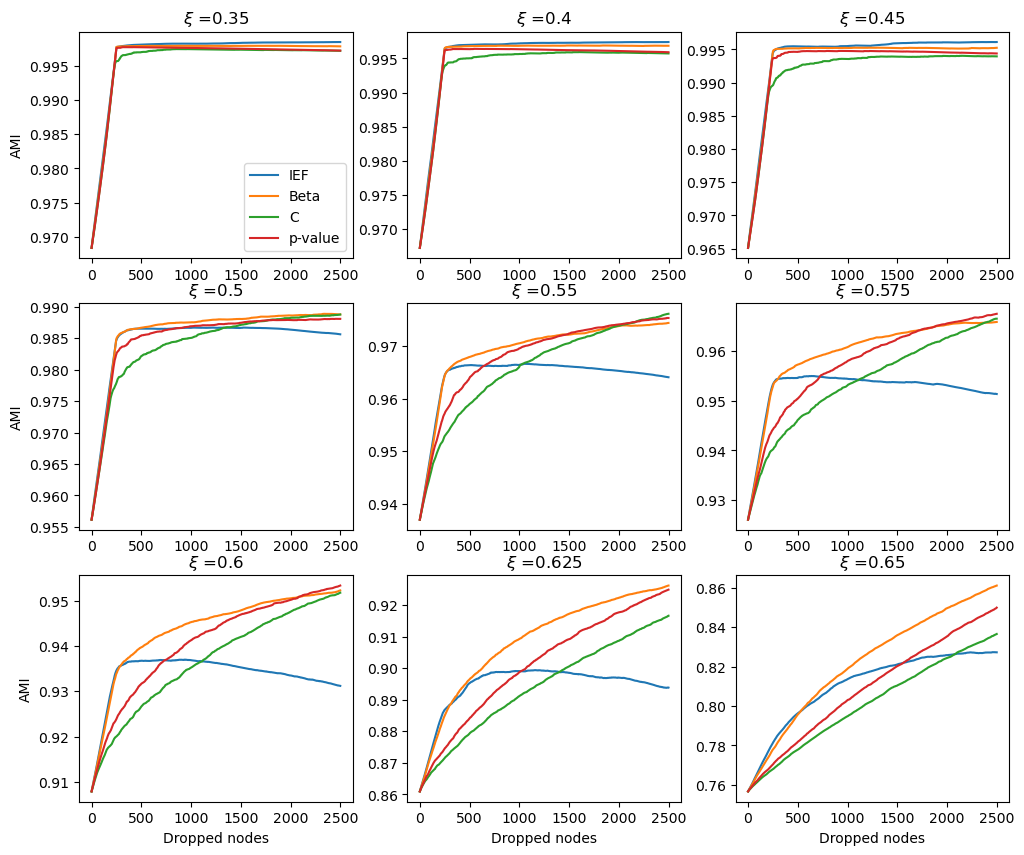

In [4]:
## Scores - only dropping 'outliers'
REP = 10
L = []
for i in range(len(XIs)):
    xi = XIs[i]
    print(xi)
    for rep in range(REP):
        random.seed(rep)
        np.random.seed(rep)
        g = build_ABCDo(xi)
        num_nodes = g.vcount()
        A = g.get_adjacency_sparse()
        g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership

        ## Compute Beta, C; M is the community membership matrix w.r.t. C and c_star 
        IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
        g.vs['IEF'] = IEF.max(axis=1).toarray().flatten()
        g.vs['beta'] = Beta.max(axis=1).toarray().flatten()
        g.vs['C'] = C.max(axis=1).toarray().flatten()
        g.vs['P'] = P.max(axis=1).toarray().flatten()

        ## rank w.r.t. top score, AMI w.r.t. original partition
        r = np.argsort(g.vs['IEF'])
        for k in range(num_nodes//4):
            L.append([xi, 'IEF', k, AMI( np.array(g.vs['leiden'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['beta'])
        for k in range(num_nodes//4):
            L.append([xi, 'beta', k, AMI( np.array(g.vs['leiden'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['C'])
        for k in range(num_nodes//4):
            L.append([xi, 'C', k, AMI( np.array(g.vs['leiden'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['P'])
        for k in range(num_nodes//4):
            L.append([xi, 'P', k, AMI( np.array(g.vs['leiden'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        

plt.figure(figsize=(12,10))
df = pd.DataFrame(L, columns=['xi','algo','dropped','ami']) 
for i in range(len(XIs)):
    xi = XIs[i]
    plt.subplot(3,3,i+1)
    D = df[df.xi==XIs[i]]
    D = D.groupby(by=['dropped','algo'])['ami'].mean()
    plt.plot(D.loc[:,'IEF'].index, D.loc[:,'IEF'], label='IEF')
    plt.plot(D.loc[:,'beta'].index, D.loc[:,'beta'], label='Beta')
    plt.plot(D.loc[:,'C'].index, D.loc[:,'C'], label='C')
    plt.plot(D.loc[:,'P'].index, D.loc[:,'P'], label='p-value')
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('Dropped nodes')
    if i%3==0:
        plt.ylabel('AMI');
    plt.title(r'$\xi$ ='+str(xi))
plt.savefig('abcdo_AMI_leiden.png');


0.35
0.4
0.45
0.5
0.55
0.575
0.6
0.625
0.65


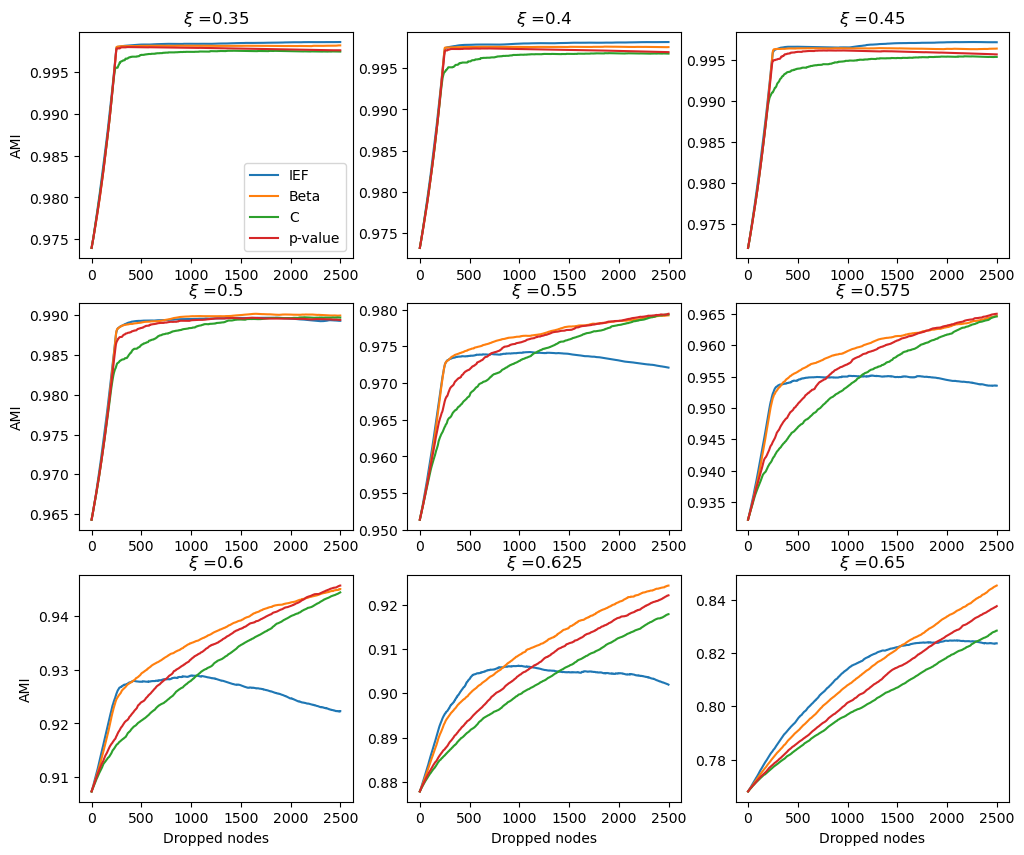

In [5]:
## Scores - using those
L = []
for i in range(len(XIs)):
    xi = XIs[i]
    print(xi)
    for rep in range(REP):
#         random.seed(rep)
#         np.random.seed(rep)
        g = build_ABCDo(xi)
        num_nodes = g.vcount()
        A = g.get_adjacency_sparse()
        g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership

        ## Compute Beta, C; M is the community membership matrix w.r.t. C and c_star 
        IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
        g.vs['IEF'] = IEF.max(axis=1).toarray().flatten()
        g.vs['IEF_top'] = np.array(IEF.argmax(axis=1)).flatten()
        g.vs['beta'] = Beta.max(axis=1).toarray().flatten()
        g.vs['beta_top'] = np.array(IEF.argmax(axis=1)).flatten()
        g.vs['C'] = C.max(axis=1).toarray().flatten()
        g.vs['C_top'] = np.array(IEF.argmax(axis=1)).flatten()
        g.vs['P'] = P.max(axis=1).toarray().flatten()
        g.vs['P_top'] = np.array(IEF.argmax(axis=1)).flatten()

        ## rank w.r.t. top score, AMI w.r.t. original partition
        r = np.argsort(g.vs['IEF'])
        for k in range(num_nodes//4):
            L.append([xi, 'IEF', k, AMI( np.array(g.vs['IEF_top'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['beta'])
        for k in range(num_nodes//4):
            L.append([xi, 'beta', k, AMI( np.array(g.vs['beta_top'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['C'])
        for k in range(num_nodes//4):
            L.append([xi, 'C', k, AMI( np.array(g.vs['C_top'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['P'])
        for k in range(num_nodes//4):
            L.append([xi, 'P', k, AMI( np.array(g.vs['P_top'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        

plt.figure(figsize=(12,10))
df = pd.DataFrame(L, columns=['xi','algo','dropped','ami']) 
for i in range(len(XIs)):
    xi = XIs[i]
    plt.subplot(3,3,i+1)
    D = df[df.xi==XIs[i]]
    D = D.groupby(by=['dropped','algo'])['ami'].mean()
    plt.plot(D.loc[:,'IEF'].index, D.loc[:,'IEF'], label='IEF')
    plt.plot(D.loc[:,'beta'].index, D.loc[:,'beta'], label='Beta')
    plt.plot(D.loc[:,'C'].index, D.loc[:,'C'], label='C')
    plt.plot(D.loc[:,'P'].index, D.loc[:,'P'], label='p-value')
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('Dropped nodes')
    if i%3==0:
        plt.ylabel('AMI');
    plt.title(r'$\xi$ ='+str(xi))
plt.savefig('abcdo_AMI_scores.png');


## Omega index

In [90]:
%%time
L = []
for xi in XIs:
    g = build_ABCDo(xi)
    gt = sparse2dict(partition2sparse(g.vs['gt']))
    del gt[0] ## drop outliers
    IEF, Beta, C, P, DegPart = CAS(g.get_adjacency_sparse(), 
                                partition2sparse(g.community_leiden(objective_function='modularity').membership))
    for th in np.arange(10,81,5)/100:
        print(xi, th)
        M = score_to_memberships(Beta, DegPart, threshold=th)
        score = omega_index.Omega(gt, sparse2dict(M)).omega_score
        ctr = Counter(np.array(M.sum(axis=1)).flatten())
        L.append(['Beta', xi, th, ctr[0], ctr[1], 10000-ctr[0]-ctr[1], score])    
        M = score_to_memberships(IEF, DegPart, threshold=th)
        score = omega_index.Omega(gt, sparse2dict(M)).omega_score
        ctr = Counter(np.array(M.sum(axis=1)).flatten())
        L.append(['IEF', xi, th, ctr[0], ctr[1], 10000-ctr[0]-ctr[1], score])


0.35 0.1
0.35 0.15
0.35 0.2
0.35 0.25
0.35 0.3
0.35 0.35
0.35 0.4
0.35 0.45
0.35 0.5
0.35 0.55
0.35 0.6
0.35 0.65
0.35 0.7
0.35 0.75
0.35 0.8
0.4 0.1
0.4 0.15
0.4 0.2
0.4 0.25
0.4 0.3
0.4 0.35
0.4 0.4
0.4 0.45
0.4 0.5
0.4 0.55
0.4 0.6
0.4 0.65
0.4 0.7
0.4 0.75
0.4 0.8
0.45 0.1
0.45 0.15
0.45 0.2
0.45 0.25
0.45 0.3
0.45 0.35
0.45 0.4
0.45 0.45
0.45 0.5
0.45 0.55
0.45 0.6
0.45 0.65
0.45 0.7
0.45 0.75
0.45 0.8
0.5 0.1
0.5 0.15
0.5 0.2
0.5 0.25
0.5 0.3
0.5 0.35
0.5 0.4
0.5 0.45
0.5 0.5
0.5 0.55
0.5 0.6
0.5 0.65
0.5 0.7
0.5 0.75
0.5 0.8
0.55 0.1
0.55 0.15
0.55 0.2
0.55 0.25
0.55 0.3
0.55 0.35
0.55 0.4
0.55 0.45
0.55 0.5
0.55 0.55
0.55 0.6
0.55 0.65
0.55 0.7
0.55 0.75
0.55 0.8
0.575 0.1
0.575 0.15
0.575 0.2
0.575 0.25
0.575 0.3
0.575 0.35
0.575 0.4
0.575 0.45
0.575 0.5
0.575 0.55
0.575 0.6
0.575 0.65
0.575 0.7
0.575 0.75
0.575 0.8
0.6 0.1
0.6 0.15
0.6 0.2
0.6 0.25
0.6 0.3
0.6 0.35
0.6 0.4
0.6 0.45
0.6 0.5
0.6 0.55
0.6 0.6
0.6 0.65
0.6 0.7
0.6 0.75
0.6 0.8
0.625 0.1
0.625 0.15
0.625 0.2
0.625

In [91]:
df = pd.DataFrame(L, columns=['algo','xi', 'threshold','0','1','2+','Omega'])

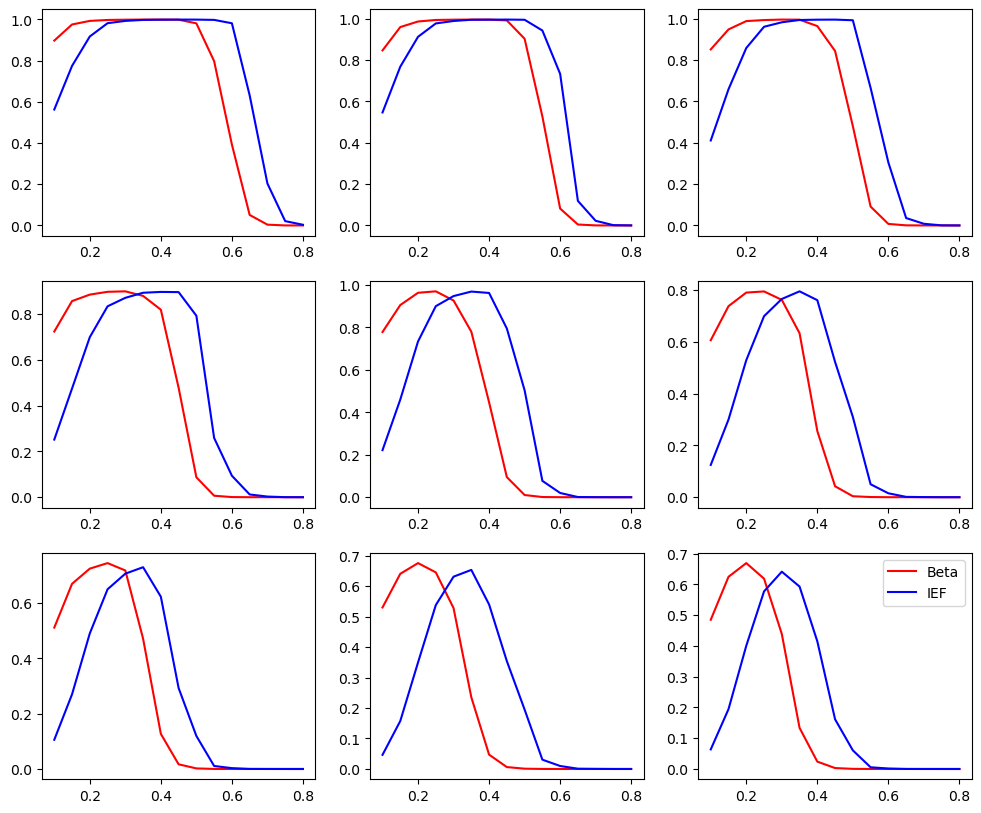

In [92]:
plt.figure(figsize=(12,10))
for i in range(len(XIs)):
    xi = XIs[i]
    plt.subplot(3,3,i+1)
    plt.plot(df[ (df.xi==xi) & (df.algo=='Beta') ]['threshold'],
             df[ (df.xi==xi) & (df.algo=='Beta') ]['Omega'], label='Beta', color='red');
    plt.plot(df[ (df.xi==xi) & (df.algo=='IEF')]['threshold'],
             df[ (df.xi==xi) & (df.algo=='IEF')]['Omega'], label='IEF', color='blue');
plt.legend();


### (2) Classify outliers - ROC curves

0.35
0.4
0.45



KeyboardInterrupt



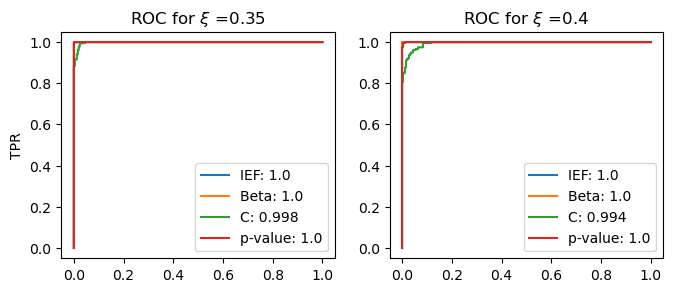

In [89]:
plt.figure(figsize=(12,10))

for i in range(len(XIs)): 
    xi = XIs[i]
    print(xi)
    g = build_ABCDo(xi)
    A = g.get_adjacency_sparse()
    ## Leiden:
    g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
    IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
    plt.subplot(3,3,i+1)

    y = [int(x>0) for x in g.vs['gt']]

    g.vs['IEF'] = IEF.max(axis=1).toarray().flatten()
    fpr, tpr, thresholds = roc_curve(y, g.vs['IEF'], pos_label=1)
    auc = AUC(y, g.vs['IEF'])
    plt.plot(fpr, tpr, label='IEF: '+str(round(auc,3)))

    g.vs['beta'] = Beta.max(axis=1).toarray().flatten()
    fpr, tpr, thresholds = roc_curve(y, g.vs['beta'], pos_label=1)
    auc = AUC(y, g.vs['beta'])
    plt.plot(fpr, tpr, label='Beta: '+str(round(auc,3)))

    g.vs['C'] = C.max(axis=1).toarray().flatten()
    fpr, tpr, thresholds = roc_curve(y, g.vs['C'], pos_label=1)
    auc = AUC(y, g.vs['C'])
    plt.plot(fpr, tpr, label='C: '+str(round(auc,3)))

    g.vs['P'] = P.max(axis=1).toarray().flatten()
    fpr, tpr, thresholds = roc_curve(y, g.vs['P'], pos_label=1)
    auc = AUC(y, g.vs['P'])
    plt.plot(fpr, tpr, label='p-value: '+str(round(auc,3)))

    plt.legend(title='AUC')
    if i>5:
        plt.xlabel('FPR')
    if i%3==0:
        plt.ylabel('TPR');
    plt.legend()
    plt.title(r'ROC for $\xi$ ='+str(xi))  
plt.savefig('abcdo_ROC_scores.png')    


### (3) Scores, varying threshold

In [5]:
%%time

range_IEF = np.arange(.05,.501,.025)
range_beta = np.arange(.05,.501,.025)
range_C = np.arange(1,8.001,.25)
range_P = np.arange(.90,1,.0025)

L = []
for xi in XIs:
    print(xi)
    g = build_ABCDo(xi)
    g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
    A = g.get_adjacency_sparse()
    IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
    for th in range_IEF:
        M = score_to_memberships(IEF, DegPart, th)
        L.append(['IEF', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])
    for th in range_beta:
        M = score_to_memberships(Beta, DegPart, th)
        L.append(['Beta', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])
    for th in range_C:
        M = score_to_memberships(C, DegPart, th)
        L.append(['C', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])
    for th in range_P:
        M = score_to_memberships(P, DegPart, th)
        L.append(['P', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])

df = pd.DataFrame(L, columns=['score','xi','threshold','outliers','TP'])
df['FP'] = df['outliers'] - df['TP']


0.35
0.4
0.45
0.5
0.55
0.575
0.6
0.625
0.65
CPU times: user 57.7 s, sys: 220 ms, total: 57.9 s
Wall time: 57.9 s


In [6]:
num_out = 250
df['sum'] = df['FP'] + df['TP']

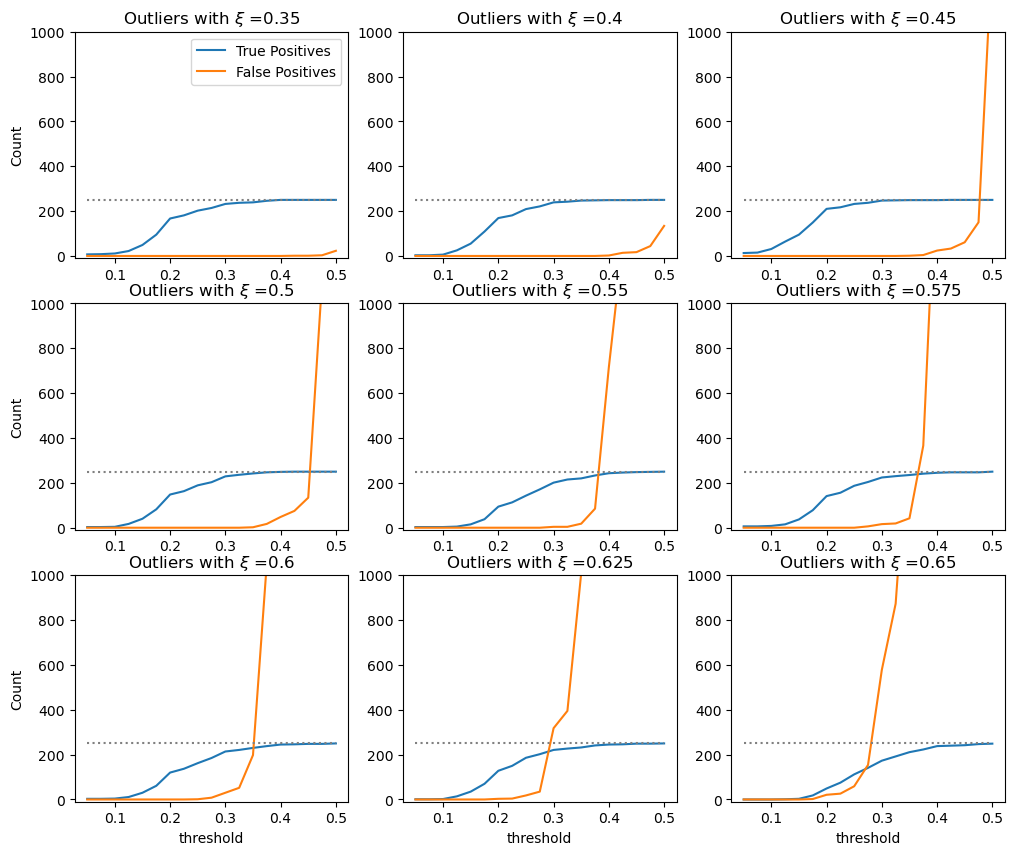

In [7]:
_df = df[df.score == 'IEF']

plt.figure(figsize=(12,10))

for i in range(len(XIs)):
    xi = XIs[i]
    D = _df[_df.xi == xi]
    plt.subplot(3,3,i+1)
    plt.plot(D.threshold, D.TP, label='True Positives')
    plt.plot(D.threshold, D.FP, label='False Positives')
    plt.hlines(y=num_out, xmin=min(D.threshold), xmax=max(D.threshold), linestyles='dotted', color='grey')
    plt.ylim((-10,1000))
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('threshold')
    if i%3==0:
        plt.ylabel('Count');
    plt.title(r'Outliers with $\xi$ ='+str(xi)) 
#plt.savefig('abcdo_TP_FP_IEF.png');    


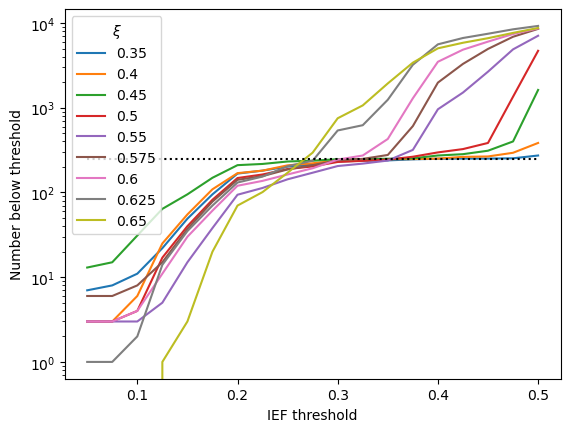

In [8]:
for xi in XIs:
    plt.semilogy(_df[_df.xi == xi]['threshold'] , _df[_df.xi == xi]['sum'], label=xi)
plt.xlabel('IEF threshold')
plt.ylabel('Number below threshold')    
plt.hlines(250,min(_df.threshold),max(_df.threshold), linestyles='dotted', color='black')
plt.legend(title=r'$\xi$')
plt.savefig('abcdo_sum_IEF.png');    


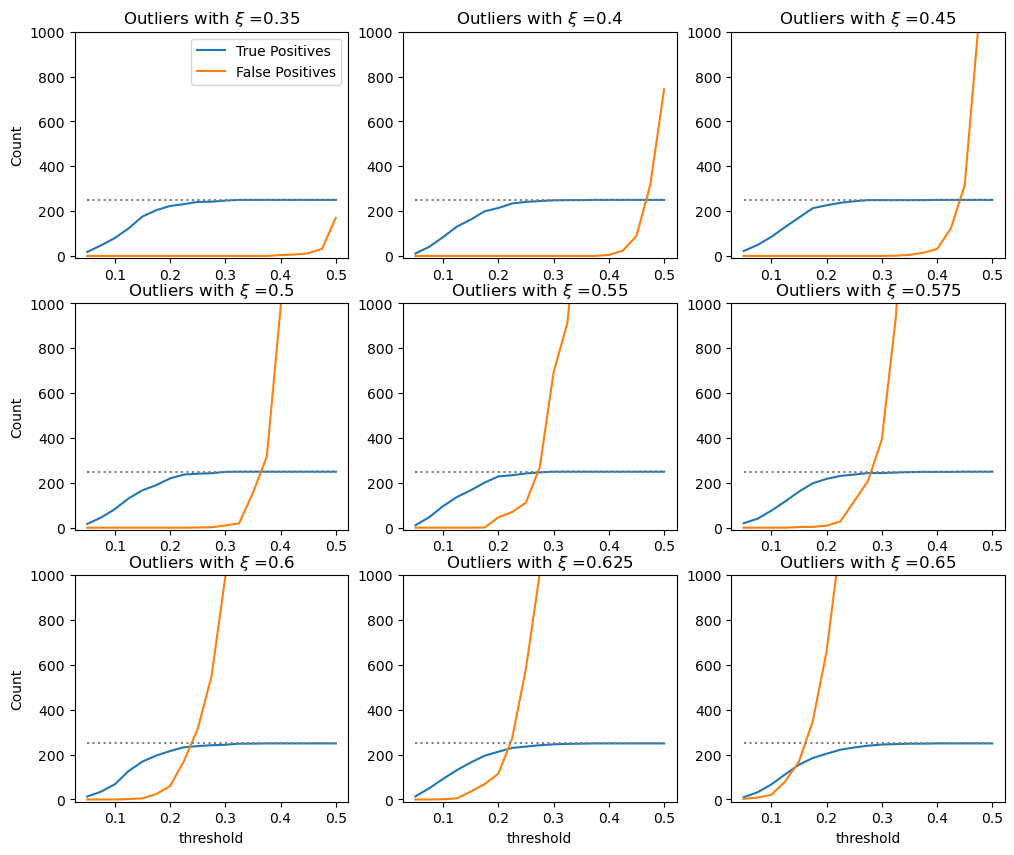

In [9]:
_df = df[df.score == 'Beta']

plt.figure(figsize=(12,10))

for i in range(len(XIs)):
    xi = XIs[i]
    D = _df[_df.xi == xi]
    plt.subplot(3,3,i+1)
    plt.plot(D.threshold, D.TP, label='True Positives')
    plt.plot(D.threshold, D.FP, label='False Positives')
    plt.hlines(y=num_out, xmin=min(D.threshold), xmax=max(D.threshold), linestyles='dotted', color='grey')
    plt.ylim((-10,1000))
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('threshold')
    if i%3==0:
        plt.ylabel('Count');
    plt.title(r'Outliers with $\xi$ ='+str(xi)) 
#plt.savefig('abcdo_TP_FP_Beta.png');    


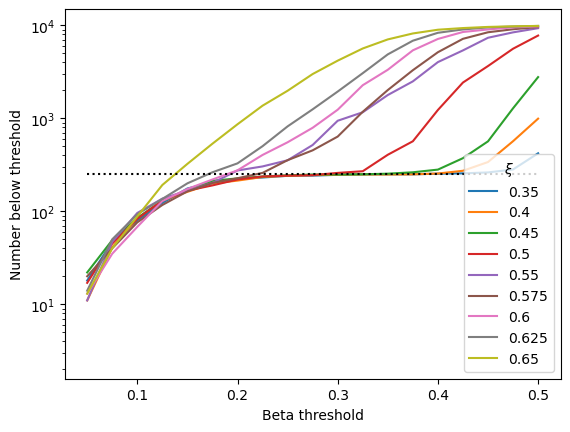

In [10]:
for xi in XIs:
    plt.semilogy(_df[_df.xi == xi]['threshold'] , _df[_df.xi == xi]['sum'], label=xi)
plt.xlabel('Beta threshold')
plt.ylabel('Number below threshold')    
plt.hlines(250,min(_df.threshold),max(_df.threshold), linestyles='dotted', color='black')
plt.legend(title=r'$\xi$')
plt.savefig('abcdo_sum_Beta.png');    


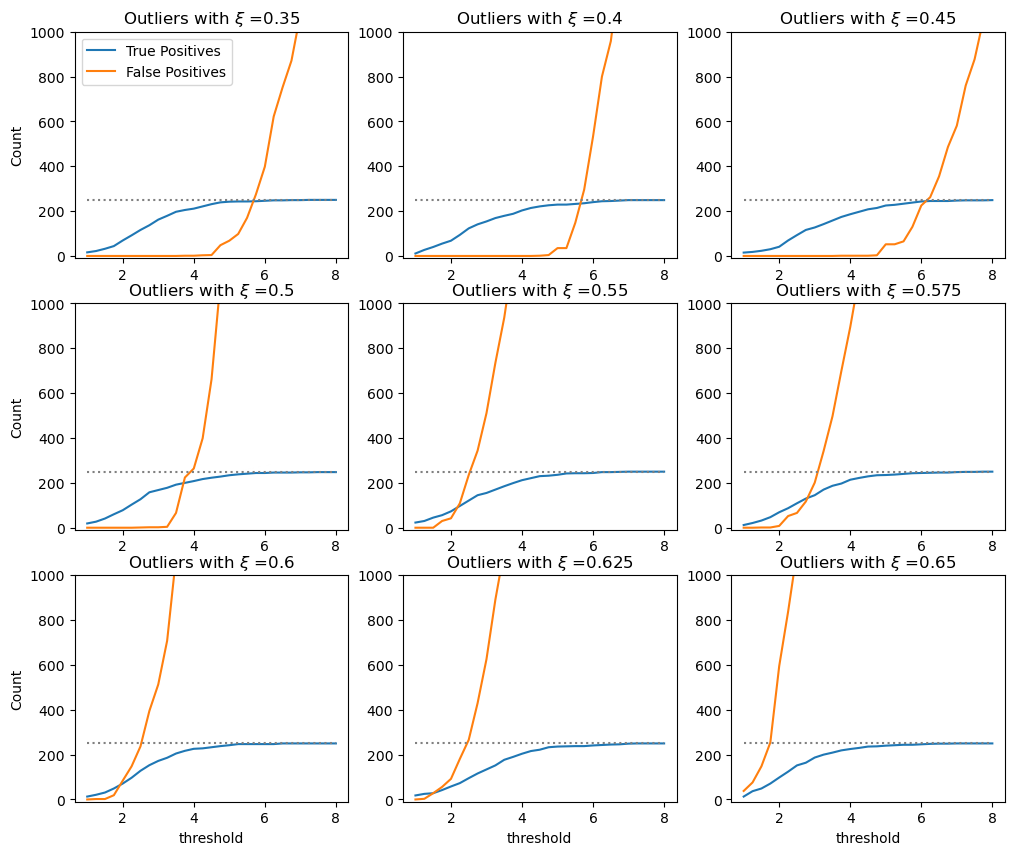

In [11]:
_df = df[df.score == 'C']

plt.figure(figsize=(12,10))

for i in range(len(XIs)):
    xi = XIs[i]
    D = _df[_df.xi == xi]
    plt.subplot(3,3,i+1)
    plt.plot(D.threshold, D.TP, label='True Positives')
    plt.plot(D.threshold, D.FP, label='False Positives')
    plt.hlines(y=num_out, xmin=min(D.threshold), xmax=max(D.threshold), linestyles='dotted', color='grey')
    plt.ylim((-10,1000))
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('threshold')
    if i%3==0:
        plt.ylabel('Count');
    plt.title(r'Outliers with $\xi$ ='+str(xi)) 
#plt.savefig('abcdo_TP_FP_C.png');    


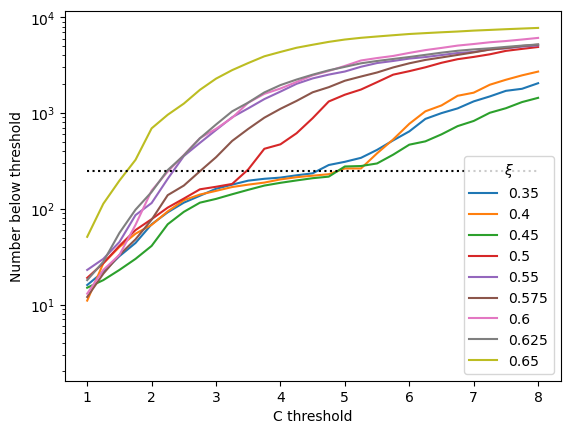

In [12]:
for xi in XIs:
    plt.semilogy(_df[_df.xi == xi]['threshold'] , _df[_df.xi == xi]['sum'], label=xi)
plt.xlabel('C threshold')
plt.ylabel('Number below threshold')    
plt.hlines(250,min(_df.threshold),max(_df.threshold), linestyles='dotted', color='black')
plt.legend(title=r'$\xi$')
plt.savefig('abcdo_sum_C.png');    


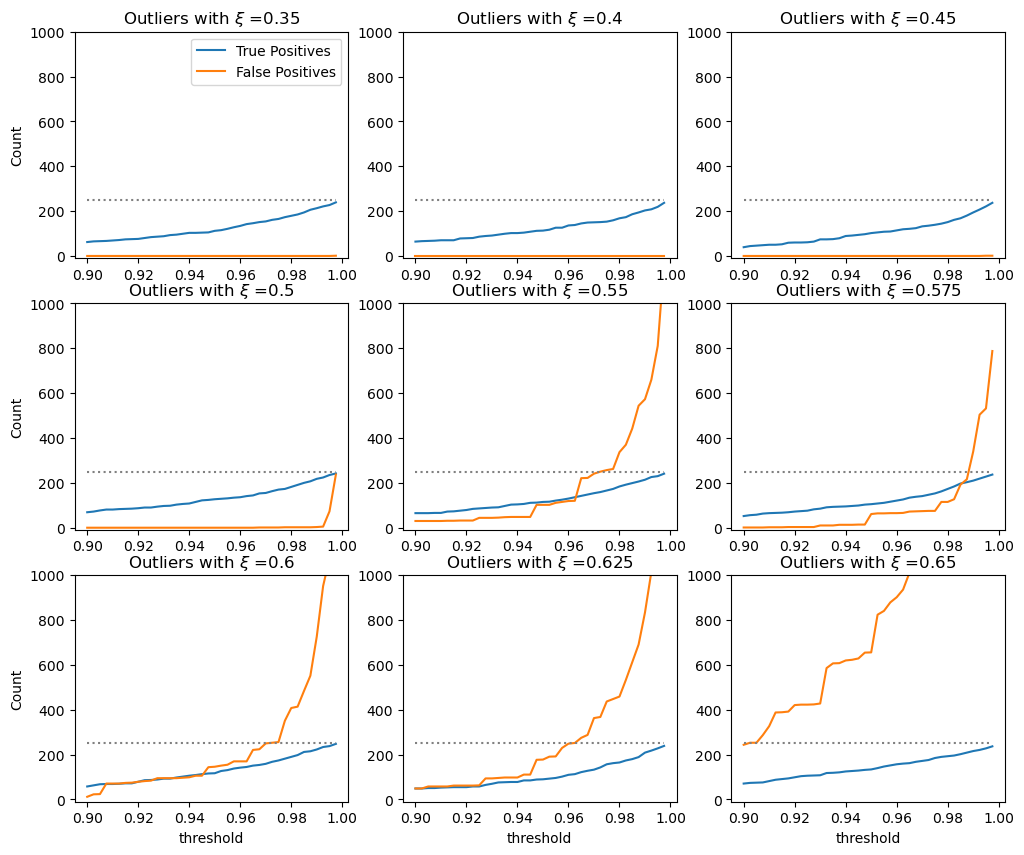

In [13]:
_df = df[df.score == 'P']

plt.figure(figsize=(12,10))

for i in range(len(XIs)):
    xi = XIs[i]
    D = _df[_df.xi == xi]
    plt.subplot(3,3,i+1)
    plt.plot(D.threshold, D.TP, label='True Positives')
    plt.plot(D.threshold, D.FP, label='False Positives')
    plt.hlines(y=num_out, xmin=min(D.threshold), xmax=max(D.threshold), linestyles='dotted', color='grey')
    plt.ylim((-10,1000))
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('threshold')
    if i%3==0:
        plt.ylabel('Count');
    plt.title(r'Outliers with $\xi$ ='+str(xi)) 
#plt.savefig('abcdo_TP_FP_P.png');    


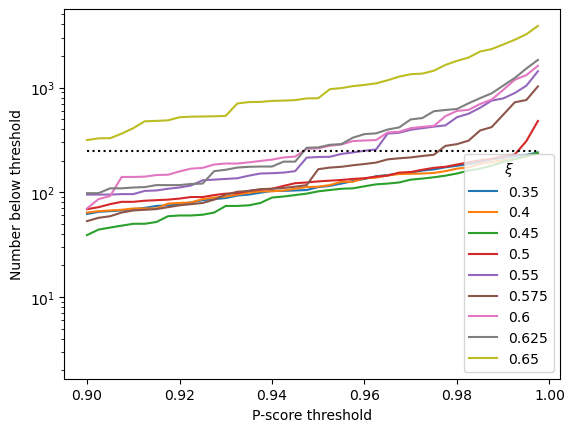

In [14]:
for xi in XIs:
    plt.semilogy(_df[_df.xi == xi]['threshold'] , _df[_df.xi == xi]['sum'], label=xi)
plt.xlabel('P-score threshold')
plt.ylabel('Number below threshold')    
plt.hlines(250,min(_df.threshold),max(_df.threshold), linestyles='dotted', color='black')
plt.legend(title=r'$\xi$')
plt.savefig('abcdo_sum_P.png');    
